In [12]:
import numpy as np
import pandas as pd 

In [13]:
import numpy as np

def sampleMF(var, fundmap, histMF, histAR, cholMF, dyn, n, stochastic=True):
    """
    Simule des scénarios trimestriels pour :
        • 5 facteurs macro (gdp, cpi, unemp, rate_3m, rate_10y)
        • 4 rendements de fonds (Obligataire, Actions, Monétaire, Immobilier)

    --------------------------------------------------------------------------
    PARAMÈTRES
    ----------
    var       : (5×6)   – 1re → 5e col = A1, 6e col = const
    fundmap   : (4×17)  – ordre : 15 betas, intercept, sigma
    histMF    : (≥2×5)  – historique macro (au moins 2 lignes)
    histAR    : (≥2×7)  – historique fonds  (seules 4 premières col. utilisées)
    cholMF    : (5×5)   – Cholesky des résidus macro
    dyn       : int     – nb de pas stochastiques avant de passer en déterministe
    n         : int     – horizon simulé (en trimestres)
    stochastic: bool    – True → tirages aléatoires, False → trajectoire moyenne
    --------------------------------------------------------------------------
    RETOUR
    ------
    ndarray de forme (n+1 , 9)  [5 macro + 4 fonds]
    """
    # -------- 1. Conversion numpy --------
    var      = np.asarray(var,      dtype=float)
    fundmap  = np.asarray(fundmap,  dtype=float)
    histMF   = np.asarray(histMF,   dtype=float)
    histAR   = np.asarray(histAR,   dtype=float)
    cholMF   = np.asarray(cholMF,   dtype=float)

    # -------- 2. Coefficients VAR --------
    A1, const = var[:, :5], var[:, 5]

    # -------- 3. Préparation des lags macro --------
    if histMF.shape[0] == 2:                         # seulement t-1 et t-0
        hmf_lags = np.vstack([histMF[0], histMF[0], histMF[1]])  # t-2 = t-1
    else:                                            # ≥3 lignes
        hmf_lags = histMF[-3:]

    # -------- 4. Point de départ --------
    hcurr = histMF[-1].copy()                        # macro t-0
    path  = [np.concatenate([hcurr, np.zeros(fundmap.shape[0])])]

    # -------- 5. Boucle de simulation --------
    for step in range(n):

        # 5-a. Bloc macro : VAR(1) + choc éventuel
        mu    = A1 @ hcurr + const
        eps   = cholMF @ np.random.randn(5) if stochastic else np.zeros(5)
        hnext = mu + eps

        # 5-b. Bloc fonds : régression linéaire + bruit idiosyncratique
        X = np.concatenate([hnext, hmf_lags[-1], hmf_lags[-2]])   # 15 facteurs
        betas      = fundmap[:, :15]
        intercepts = fundmap[:, 15]
        sigma      = fundmap[:, 16]
        det_part   = betas @ X
        rand_part  = np.random.randn(fundmap.shape[0]) * sigma if stochastic else 0
        anext      = det_part + intercepts + rand_part            # 4 rendements

        # 5-c. Mise à jour des lags et stockage
        hmf_lags = np.vstack([hmf_lags[1:], hnext])
        path.append(np.concatenate([hnext, anext]))
        hcurr = hnext.copy()

        # 5-d. Bascule éventuelle en déterministe après dyn pas
        if stochastic and step + 1 == dyn:
            stochastic = False

    return np.asarray(path)


In [20]:
cholMF = pd.read_csv("var1chol.csv")


In [21]:
cholMF

,V1,V2,V3,V4,V5
0,227.367864,0.000000,0.000000,0.000000,0.000000
1,0.643940,1.282779,0.000000,0.000000,0.000000
2,-0.578446,0.124524,0.318975,0.000000,0.000000
3,0.043549,0.088965,0.021186,0.370702,0.000000
4,0.092636,0.151110,0.029621,0.209089,0.375801


In [22]:
cholMF = cholMF.values.astype(float)

In [23]:
cholMF

array([[ 2.27367864e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 6.43940420e-01,  1.28277933e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-5.78445918e-01,  1.24524420e-01,  3.18975213e-01,
         0.00000000e+00,  0.00000000e+00],
       [ 4.35486777e-02,  8.89653078e-02,  2.11855457e-02,
         3.70702213e-01,  0.00000000e+00],
       [ 9.26363007e-02,  1.51109521e-01,  2.96205488e-02,
         2.09088552e-01,  3.75800520e-01]])

In [24]:
# 1. 
import numpy as np
import pandas as pd

# 2. 📂 Lire les fichiers CSV
df_var = pd.read_csv("var.csv", index_col=0) # pour que la 1er colonne (colonne d’index 0) du fichier CSV doit être utilisée comme index (étiquettes de lignes) du DataFrame.
df_fundmap = pd.read_csv("mapping_matrix.csv", index_col=0)
histMF = pd.read_csv("histMF.csv")        # (2 lignes × 5 colonnes)
histAR = pd.read_csv("histAR.csv")        # (2 lignes × ≥4 colonnes)
cholMF = pd.read_csv("var1chol.csv")  # (5×5)

# 3. 🧠 Transformer en matrices numpy
var      = df_var.values                  # (5×6)
fundmap  = df_fundmap.values              # (4×17)
histMF   = histMF.values                  # (2×5)
histAR   = histAR.values                  # (2×7 ou plus)

cholMF = cholMF.values.astype(float)                # (5×5)

# 4. 🚀 Appel de la fonction sampleMF
# Exemple : simulation de 40 trimestres (10 ans)
result = sampleMF(
    var=var,
    fundmap=fundmap,
    histMF=histMF,
    histAR=histAR,
    cholMF=cholMF,
    dyn=0,            # 0 → tout stochastique
    n=40,             # 40 trimestres simulés
    stochastic=True
)

# 5. ✅ Afficher la forme du résultat
print("Résultat shape :", result.shape)  # (41, 9)

# 6. (Optionnel) Voir les 5 premières lignes
print("Aperçu :")
print(pd.DataFrame(result).head())


Résultat shape : (41, 9)
Aperçu :
              0           1          2         3          4         5  \
0  29962.047000  319.615000   4.200000  4.200000   4.280000  0.000000   
1  22893.714814  146.948759 -19.545678 -0.077137  10.142241 -0.362090   
2   9088.022924   73.844383  -6.042861  0.102369   5.873009  0.005742   
3   3923.330042   29.191133  -2.248326 -0.717438   0.925445  0.017666   
4   1743.979700   14.341673  -0.729000 -0.319728   0.774322  0.029650   

          6         7         8  
0  0.000000  0.000000  0.000000  
1 -1.406216 -0.019804  0.024153  
2  0.010247  0.025856 -0.307953  
3 -0.322428 -0.006632 -0.218800  
4 -0.165836  0.005512 -0.088548  


In [25]:
columns = [
    "gdp", "cpi", "unemp", "rate_3m", "rate_10y",
    "fond_obligataire", "actions", "monétaire", "immobilier"
]

df_result = pd.DataFrame(result, columns=columns)
print(df_result.head())


            gdp         cpi      unemp   rate_3m   rate_10y  fond_obligataire  \
0  29962.047000  319.615000   4.200000  4.200000   4.280000          0.000000   
1  22893.714814  146.948759 -19.545678 -0.077137  10.142241         -0.362090   
2   9088.022924   73.844383  -6.042861  0.102369   5.873009          0.005742   
3   3923.330042   29.191133  -2.248326 -0.717438   0.925445          0.017666   
4   1743.979700   14.341673  -0.729000 -0.319728   0.774322          0.029650   

    actions  monétaire  immobilier  
0  0.000000   0.000000    0.000000  
1 -1.406216  -0.019804    0.024153  
2  0.010247   0.025856   -0.307953  
3 -0.322428  -0.006632   -0.218800  
4 -0.165836   0.005512   -0.088548  


In [26]:
df_result.to_csv("scenarios_simules.csv", index=False)


In [27]:
# affichage de scenarios_simules.csv
scenarios = pd.read_csv("scenarios_simules.csv")
scenarios


,gdp,cpi,unemp,rate_3m,rate_10y,fond_obligataire,actions,monétaire,immobilier
0,29962.047000,319.615000,4.200000,4.200000,4.280000,0.000000,0.000000,0.000000,0.000000
1,22893.714814,146.948759,-19.545678,-0.077137,10.142241,-0.362090,-1.406216,-0.019804,0.024153
2,9088.022924,73.844383,-6.042861,0.102369,5.873009,0.005742,0.010247,0.025856,-0.307953
3,3923.330042,29.191133,-2.248326,-0.717438,0.925445,0.017666,-0.322428,-0.006632,-0.218800
4,1743.979700,14.341673,-0.729000,-0.319728,0.774322,0.029650,-0.165836,0.005512,-0.088548
5,962.485950,5.535352,-0.302809,-0.612171,-0.561445,0.049533,-0.183560,-0.004885,-0.033158
6,589.694067,1.864450,-0.543374,-0.661523,0.357778,0.008407,-0.098408,-0.003246,-0.005373
7,21.181059,1.505468,0.416289,-0.721414,-1.002398,0.050228,-0.181392,-0.002209,-0.026557
8,-222.710938,-1.733795,0.804841,-1.176643,-0.847187,0.029056,-0.206810,-0.007048,-0.009947
9,-432.726739,0.589533,1.385714,-1.331238,0.102657,0.043539,-0.136616,-0.001857,-0.054077


In [ ]:
# 1000 scénarios 

In [30]:
import numpy as np
from scipy.interpolate import interp1d

def curve_fitting(rates, maturities=np.array([0.25, 1, 2, 3, 5, 7, 10, 20, 30]),
                  interpolation="linear", extrapolation="cfr", long_term_rate=0.04):
    """
    Génére une courbe de taux complète (jusqu'à 100 ans) à partir de points discrets.

    Paramètres :
    - rates : np.array – taux observés (ex: [0.01, 0.012, ...])
    - maturities : np.array – maturités correspondantes (ex: [0.25, 1, 2, ...])
    - interpolation : "linear" ou "cubic" – méthode d'interpolation entre les points
    - extrapolation : "cfr" ou "poly" – méthode d'extrapolation après la dernière maturité
    - long_term_rate : float – taux cible à 100 ans si extrapolation = "poly"

    Retourne :
    - maturité_complete, taux_complet : deux vecteurs numpy de même longueur
    """

    t_min = maturities[0]
    t_max = maturities[-1]
    t_before_last = maturities[-2]

    # 1. Interpolation : trimestrielle jusqu'à la dernière maturité observée
    maturité_interpolée = np.linspace(t_min, t_max, int(round((t_max - t_min) * 4 + 1))) # Crée un vecteur numpy contenant n points entre t_min et t_max inclus.
    interpolation_fonction = interp1d(maturities, rates, kind=interpolation)
    taux_interpolé = interpolation_fonction(maturité_interpolée)

    # 2. Extrapolation jusqu'à 100 ans
    maturité_extrapolée = np.linspace(t_max + 0.25, 100, int(round((100 - t_max) * 4)))
    taux_extrapolé = []

    if extrapolation == "cfr":
        dernier_taux = rates[-1]
        avant_dernier_taux = rates[-2]
        taux_forward_const = ((1 + dernier_taux) ** t_max / (1 + avant_dernier_taux) ** t_before_last) ** (1 / (t_max - t_before_last)) - 1
        facteur_cumulé = (1 + dernier_taux) ** t_max
        for t in maturité_extrapolée:
            facteur_cumulé *= (1 + taux_forward_const) ** 0.25
            taux_extrapolé.append(facteur_cumulé ** (1 / t) - 1)
    else:
        # extrapolation polynomiale de degré 2
        coefficients_poly = np.polyfit(
            [t_before_last, t_max, 100],
            [rates[-2], rates[-1], long_term_rate],
            deg=2
        )
        polynome = np.poly1d(coefficients_poly)
        taux_extrapolé = polynome(maturité_extrapolée)

    # 3. Fusion des résultats
    maturité_complete = np.concatenate([maturité_interpolée, maturité_extrapolée])
    taux_complet = np.concatenate([taux_interpolé, taux_extrapolé])

    return maturité_complete, taux_complet


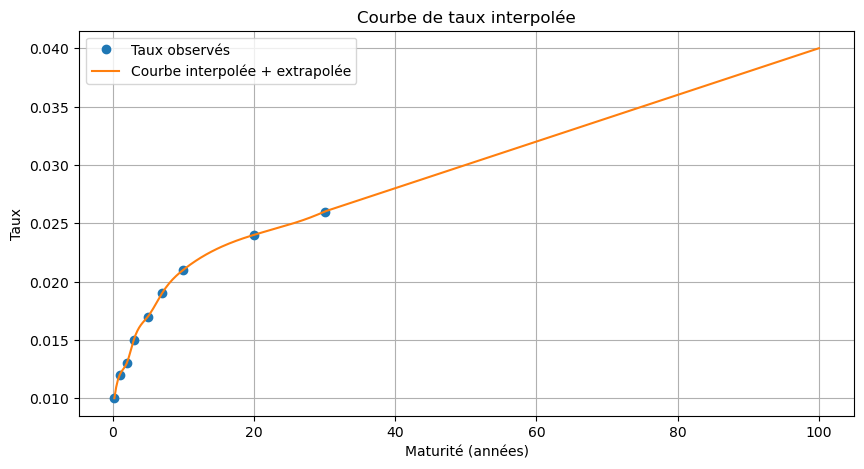

In [31]:
# test de la fct curve_fitting
import numpy as np
import matplotlib.pyplot as plt


taux_observés = np.array([0.01, 0.012, 0.013, 0.015, 0.017, 0.019, 0.021, 0.024, 0.026])  # soit 1% à 2.6%
maturités_observées = np.array([0.25, 1, 2, 3, 5, 7, 10, 20, 30])  # en années

x, y = curve_fitting(
    rates=taux_observés,
    maturities=maturités_observées,
    interpolation="cubic",       # ou "linear"
    extrapolation="poly",         # ou "poly"
    long_term_rate=0.04          # taux cible à 100 ans (si poly)
)

# 3. Affichage graphique (facultatif mais recommandé)
plt.figure(figsize=(10,5))
plt.plot(maturités_observées, taux_observés, "o", label="Taux observés")
plt.plot(x, y, label="Courbe interpolée + extrapolée")
plt.xlabel("Maturité (années)")
plt.ylabel("Taux")
plt.title("Courbe de taux interpolée")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
#  valoriser une obligation fixe à partir de la courbe de taux zéro qu on onbtient avec  curve_fitting.
# Calculer la valeur actuelle d’une obligation (le prix auquel on devrait l’acheter aujourd’hui) en actualisant tous ses flux futurs (coupons + remboursement final) avec les taux d’intérêt zéro-coupon du marché.
import numpy as np
from scipy.interpolate import interp1d

def bond_price(zero_maturities,
               zero_rates,
               maturity,                 # durée de vie totale de l’obligation (années)
               coupon_rate,
               freq=1,                   # fréquence des coupons (1 = annuel, 2 = semestriel, 4 = trimestriel)
               redemption=100,
               interp_kind="linear",
               extrap_kind="cfr",
               long_rate_target=0.04):
    """
    Calcule le prix théorique (clean price) d'une obligation à taux fixe.

    Paramètres
    ----------
    zero_maturities  : np.array – maturités des points zéro (ex. [0.25, 1, 2, ...])
    zero_rates       : np.array – taux zéro correspondants (en décimal)
    maturity         : float    – maturité finale de l'obligation (en années)
    coupon_rate      : float    – coupon nominal annuel (ex. 0.03 pour 3 %)
    freq             : int      – nombre de paiements de coupon par an
    redemption       : float    – valeur nominale remboursée à l'échéance
    interp_kind      : "linear" ou "cubic"
    extrap_kind      : "cfr" ou "poly"
    long_rate_target : float    – taux cible à 100 ans si extrap_kind="poly"

    Retour
    ------
    float – prix théorique de l'obligation
    """

    #   Construction de la courbe zéro-rates complète (trimestrielle jusqu’à 100 ans)
    times, zero_curve = curve_fitting(
        rates=zero_rates,
        maturities=zero_maturities,
        interpolation=interp_kind,
        extrapolation=extrap_kind,
        long_term_rate=long_rate_target
    )

    # Interpolateur continu R(t) pour lire un taux zéro à n’importe quelle maturité
    R = interp1d(times, zero_curve, kind="linear", fill_value="extrapolate")

    #  Calendrier des flux de coupon
    dt   = 1 / freq                        # pas entre coupons
    n_cf = int(round(maturity * freq))     # nombre total de coupons
    cashflow_times = np.arange(dt, n_cf*dt + 1e-9, dt)   # 0.25, 0.50, ...

    #  Prix = somme des coupons actualisés + remboursement actualisé
    pv = 0.0
    for t in cashflow_times[:-1]:          # tous sauf le dernier
        pv += redemption * coupon_rate / freq / (1 + R(t))**t
    # dernier flux = coupon + redemption
    T  = cashflow_times[-1]
    pv += redemption * (1 + coupon_rate / freq) / (1 + R(T))**T

    return pv
